# Assignment 4: Kürten

In this assignment I will not look at kernels directly, because the mechanistic kernel interpretation did not work well. Instead, I will look at similarities between different embeddings.
This is of course a bit biased towards the model, because we trained the encoder with ViT.

We are quite limited, due to our training regime: we trained on different data for each model, also within subject different data. This is why we cannot compare the embeddings between subjects and also not within a subject... (this has to be adapted in the future).

So I will only observe scenarios across modalities and within the same subject.
I will check to which model the CNN and transformer eye movement embeddings are most similar to. It will most likely be ViT because it was trained on it, but also I had non linearities to the latent space, so they could also be completely unrelated (spoilers).

For this I will first get the embeddings for the eye and image data for each model. Then I calculate the RDMs for the eye embeddings and the image embeddings.

Then I compare when in the CNN it gets similar to ViT (and if it does so at all) and compare the final embedding to other vision encoders.

As mentioned before, I will use the representations before the projection heads.

## 1. Load and prepare the models
I need for both subjects the CNN and transformer model. Then I will only take the correct test trials and compare the embeddings.
Also I need ViT, VGG16 and ResNet50 embeddings.

In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import sys
# add contrastive eye image to path
sys.path.insert(0, '..')
import contrastive_eye_image.transformer_cl_model as tf
import contrastive_eye_image.cnn_cl_model as cnn
import pickle
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

Since it did not work for us, to run Jupyter notebooks on the server, I will load the models from my local machine. Also for this part, Saskia and I use the same code and mechanics.

In [2]:
sub1_cnn = torch.load("../../models/sub1/cnn/cnn_CL_2_1000_0-0003_50/checkpoint.pth", map_location=torch.device('cpu'))
sub1_cnn_model = cnn.ContrastiveModel_cnn()
sub1_cnn_model.load_state_dict(sub1_cnn['state_dict'])
sub1_cnn_model.eval()
sub1_tf = torch.load("../../models/sub1/tf/transformer_CL_2_1000_0-0003_50/checkpoint.pth", map_location=torch.device('cpu'))
sub1_tf_model = tf.ContrastiveModel_tf()
sub1_tf_model.load_state_dict(sub1_tf['state_dict'])
sub1_tf_model.eval()
sub2_cnn = torch.load("../../models/sub2/cnn/cnn_CL_2_1000_0-0003_50/checkpoint.pth", map_location=torch.device('cpu'))
sub2_cnn_model = cnn.ContrastiveModel_cnn()
sub2_cnn_model.load_state_dict(sub2_cnn['state_dict'])
sub2_cnn_model.eval()
sub2_tf = torch.load("../../models/sub2/tf/transformer_CL_2_1000_0-0003_50/checkpoint.pth", map_location=torch.device('cpu'))
sub2_tf_model = tf.ContrastiveModel_tf()
sub2_tf_model.load_state_dict(sub2_tf['state_dict'])
sub2_tf_model.eval()

# the vit is already included in the models and does not need to be loaded
vit = sub1_cnn_model.image_encoder

# take only the encoder for all models
sub1_cnn_model = sub1_cnn_model.eye_encoder
sub1_tf_model = sub1_tf_model.eye_encoder
sub2_cnn_model = sub2_cnn_model.eye_encoder
sub2_tf_model = sub2_tf_model.eye_encoder

# vgg16
vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
vgg16.eval()
# resnet50
resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Now I need to get rid of the classification layers in vgg and resnet.

In [3]:
vgg16 = vgg16.features
resnet50 = torch.nn.Sequential(*(list(resnet50.children())[:-1]))

In [4]:
print(vgg16)
print(resnet50)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Load the data
I will reuse the data from the tasks. I only need the correct test trials.

In [5]:
def get_data(path):
    test_path = path + "/eval_test.pkl"
    with open(test_path, 'rb') as f:
        eval_data = pickle.load(f)
    return eval_data

In [6]:
def get_spec_trials(data):
    corr_mask = np.array(data["val_true"]) > np.array(data["val_false"])
    eye = np.array(data["eye_data"])[corr_mask]
    image = np.array(data["image_true"])[corr_mask]
    return eye, image

In [7]:
sub1_cnn_eye_gt, sub1_cnn_img = get_spec_trials(get_data("../../models/sub1/cnn/cnn_CL_2_1000_0-0003_50"))
sub1_tf_eye_gt, sub1_tf_img = get_spec_trials(get_data("../../models/sub1/tf/transformer_CL_2_1000_0-0003_50"))
sub2_cnn_eye_gt, sub2_cnn_img = get_spec_trials(get_data("../../models/sub2/cnn/cnn_CL_2_1000_0-0003_50"))
sub2_tf_eye_gt, sub2_tf_img = get_spec_trials(get_data("../../models/sub2/tf/transformer_CL_2_1000_0-0003_50"))

Reading the classes csv, to see what image ID matches to what image.

In [8]:
classes = pd.read_csv("../../models/categories.csv")
# match to image ids
print(classes[classes["things_image_nr"] == sub1_cnn_img[0]]["image_path"].values[0])

knitting_needle/knitting_needle_06s.jpg


Since I cannot use the server, I will use the things dataset on a hard drive. And I wrote a function to get the embeddings per image model.

In [9]:
im_dir = "/mnt/d/deeplearn_data/images/images/"

def get_image_embeddings(model, im_gt, transform):
    embeddings = []
    for im in tqdm(im_gt):
        im_path = classes[classes["things_image_nr"] == im]["image_path"].values[0]
        im = Image.open(im_dir + im_path)
        im = transform(im)
        im = im.unsqueeze(0)
        with torch.no_grad():
            embeddings.append(model(im).detach().flatten().numpy())
    return np.array(embeddings)

Now lets get for each of the 4 models the embeddings for the images.

In [12]:
sub1_cnn_img_vit = get_image_embeddings(vit, sub1_cnn_img, torchvision.models.ViT_B_32_Weights.IMAGENET1K_V1.transforms())
sub1_cnn_img_vgg16 = get_image_embeddings(vgg16, sub1_cnn_img, torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms())
sub1_cnn_img_resnet50 = get_image_embeddings(resnet50, sub1_cnn_img, torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms())

sub1_tf_img_vit = get_image_embeddings(vit, sub1_tf_img, torchvision.models.ViT_B_32_Weights.IMAGENET1K_V1.transforms())
sub1_tf_img_vgg16 = get_image_embeddings(vgg16, sub1_tf_img, torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms())
sub1_tf_img_resnet50 = get_image_embeddings(resnet50, sub1_tf_img, torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms())

sub2_cnn_img_vit = get_image_embeddings(vit, sub2_cnn_img, torchvision.models.ViT_B_32_Weights.IMAGENET1K_V1.transforms())
sub2_cnn_img_vgg16 = get_image_embeddings(vgg16, sub2_cnn_img, torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms())
sub2_cnn_img_resnet50 = get_image_embeddings(resnet50, sub2_cnn_img, torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms())

sub2_tf_img_vit = get_image_embeddings(vit, sub2_tf_img, torchvision.models.ViT_B_32_Weights.IMAGENET1K_V1.transforms())
sub2_tf_img_vgg16 = get_image_embeddings(vgg16, sub2_tf_img, torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms())
sub2_tf_img_resnet50 = get_image_embeddings(resnet50, sub2_tf_img, torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms())

100%|██████████| 2648/2648 [05:47<00:00,  7.63it/s]


Pickle all for safety. It takes over an hour...

In [13]:
# pickle all to be safe
with open("sub1_cnn_img_vit.pkl", "wb") as f:
    pickle.dump(sub1_cnn_img_vit, f)
with open("sub1_cnn_img_vgg16.pkl", "wb") as f:
    pickle.dump(sub1_cnn_img_vgg16, f)
with open("sub1_cnn_img_resnet50.pkl", "wb") as f:
    pickle.dump(sub1_cnn_img_resnet50, f)
with open("sub1_tf_img_vit.pkl", "wb") as f:
    pickle.dump(sub1_tf_img_vit, f)
with open("sub1_tf_img_vgg16.pkl", "wb") as f:
    pickle.dump(sub1_tf_img_vgg16, f)
with open("sub1_tf_img_resnet50.pkl", "wb") as f:
    pickle.dump(sub1_tf_img_resnet50, f)
with open("sub2_cnn_img_vit.pkl", "wb") as f:
    pickle.dump(sub2_cnn_img_vit, f)
with open("sub2_cnn_img_vgg16.pkl", "wb") as f:
    pickle.dump(sub2_cnn_img_vgg16, f)
with open("sub2_cnn_img_resnet50.pkl", "wb") as f:
    pickle.dump(sub2_cnn_img_resnet50, f)
with open("sub2_tf_img_vit.pkl", "wb") as f:
    pickle.dump(sub2_tf_img_vit, f)
with open("sub2_tf_img_vgg16.pkl", "wb") as f:
    pickle.dump(sub2_tf_img_vgg16, f)
with open("sub2_tf_img_resnet50.pkl", "wb") as f:
    pickle.dump(sub2_tf_img_resnet50, f)

Read all again

In [10]:
# pickle all to be safe
with open("sub1_cnn_img_vit.pkl", "rb") as f:
    sub1_cnn_img_vit = pickle.load(f)
with open("sub1_cnn_img_vgg16.pkl", "rb") as f:
    sub1_cnn_img_vgg16 = pickle.load(f)
with open("sub1_cnn_img_resnet50.pkl", "rb") as f:
    sub1_cnn_img_resnet50 = pickle.load(f)
with open("sub1_tf_img_vit.pkl", "rb") as f:
    sub1_tf_img_vit = pickle.load(f)
with open("sub1_tf_img_vgg16.pkl", "rb") as f:
    sub1_tf_img_vgg16 = pickle.load(f)
with open("sub1_tf_img_resnet50.pkl", "rb") as f:
    sub1_tf_img_resnet50 = pickle.load(f)
with open("sub2_cnn_img_vit.pkl", "rb") as f:
    sub2_cnn_img_vit = pickle.load(f)
with open("sub2_cnn_img_vgg16.pkl", "rb") as f:
    sub2_cnn_img_vgg16 = pickle.load(f)
with open("sub2_cnn_img_resnet50.pkl", "rb") as f:
    sub2_cnn_img_resnet50 = pickle.load(f)
with open("sub2_tf_img_vit.pkl", "rb") as f:
    sub2_tf_img_vit = pickle.load(f)
with open("sub2_tf_img_vgg16.pkl", "rb") as f:
    sub2_tf_img_vgg16 = pickle.load(f)
with open("sub2_tf_img_resnet50.pkl", "rb") as f:
    sub2_tf_img_resnet50 = pickle.load(f)

And I also need our eye embeddings.

In [21]:
def get_eye_embeddings(model, eye):
    embeddings = []
    with torch.no_grad():
        for e in tqdm(eye):
            e = torch.from_numpy(e).float().unsqueeze(0)
            embeddings.append(model(e).float().detach().flatten().numpy())
    return np.array(embeddings)

In [15]:
sub1_cnn_eye = get_eye_embeddings(sub1_cnn_model, sub1_cnn_eye_gt)
sub1_tf_eye = get_eye_embeddings(sub1_tf_model, sub1_tf_eye_gt)
sub2_cnn_eye = get_eye_embeddings(sub2_cnn_model, sub2_cnn_eye_gt)
sub2_tf_eye = get_eye_embeddings(sub2_tf_model, sub2_tf_eye_gt)

100%|██████████| 2648/2648 [01:21<00:00, 32.66it/s]


In [16]:
with open("sub1_cnn_eye.pkl", "wb") as f:
    pickle.dump(sub1_cnn_eye, f)
with open("sub1_tf_eye.pkl", "wb") as f:
    pickle.dump(sub1_tf_eye, f)
with open("sub2_cnn_eye.pkl", "wb") as f:
    pickle.dump(sub2_cnn_eye, f)
with open("sub2_tf_eye.pkl", "wb") as f:
    pickle.dump(sub2_tf_eye, f)

In [12]:
# read
with open("sub1_cnn_eye.pkl", "rb") as f:
    sub1_cnn_eye = pickle.load(f)
with open("sub1_tf_eye.pkl", "rb") as f:
    sub1_tf_eye = pickle.load(f)
with open("sub2_cnn_eye.pkl", "rb") as f:
    sub2_cnn_eye = pickle.load(f)
with open("sub2_tf_eye.pkl", "rb") as f:
    sub2_tf_eye = pickle.load(f)

## RDM calculation and plotting
Now importantly, compared to the lesson on the RSA topic (https://deeplearning-jupyterbook.github.io/notebooks/intro-to-rsa.html), I will use the cosine similarity instead of the euclidean distance. This is because or model was trained on cosine similarity and I care about relative similarity, not distance in representational space.

In [13]:
def get_rdm(embeddings):
    rdm = np.zeros((len(embeddings), len(embeddings)))
    for i in range(len(embeddings)):
        for j in range(len(embeddings)):
            # cosine similarity
            rdm[i, j] = 1 - np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
    return rdm

In [14]:
def viz_rdm(rdm, title="RDM"):
    plt.imshow(rdm, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.show()

Now lets get the RDMs for the eye embeddings.

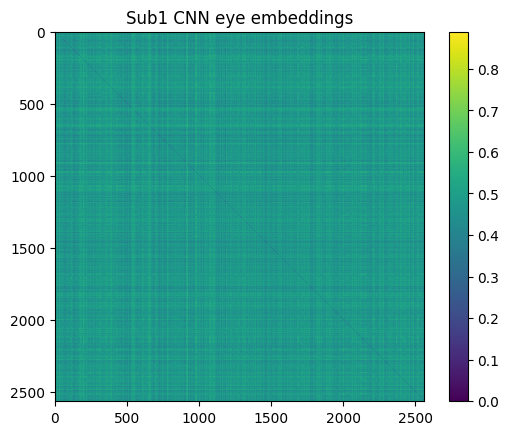

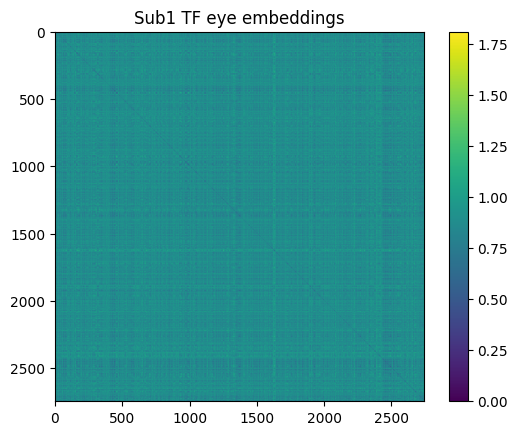

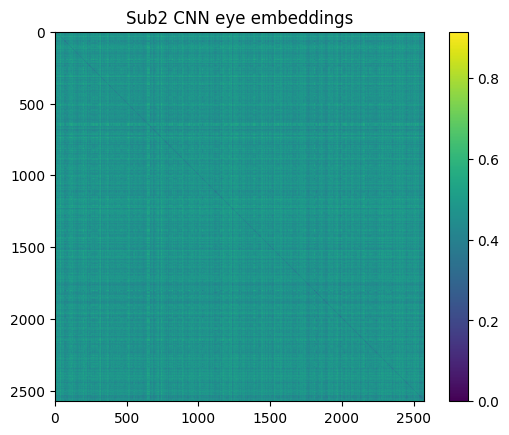

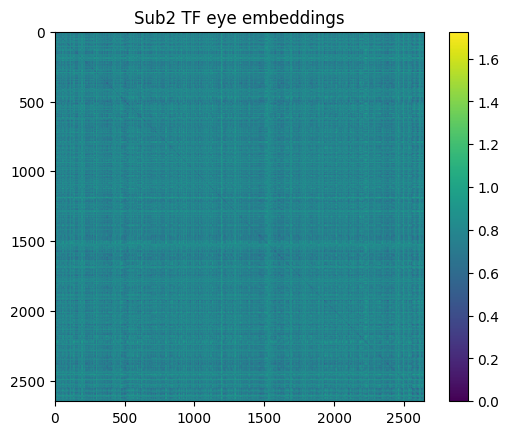

In [13]:
sub1_cnn_eye_rdm = get_rdm(sub1_cnn_eye)
sub1_tf_eye_rdm = get_rdm(sub1_tf_eye)
sub2_cnn_eye_rdm = get_rdm(sub2_cnn_eye)
sub2_tf_eye_rdm = get_rdm(sub2_tf_eye)

viz_rdm(sub1_cnn_eye_rdm, "Sub1 CNN eye embeddings")
viz_rdm(sub1_tf_eye_rdm, "Sub1 TF eye embeddings")
viz_rdm(sub2_cnn_eye_rdm, "Sub2 CNN eye embeddings")
viz_rdm(sub2_tf_eye_rdm, "Sub2 TF eye embeddings")

Now lets go for the vision embeddings.

In [14]:
sub1_cnn_img_vit_rdm = get_rdm(sub1_cnn_img_vit)
sub2_cnn_img_vit_rdm = get_rdm(sub2_cnn_img_vit)

In [14]:
sub1_cnn_img_vgg16_rdm = get_rdm(sub1_cnn_img_vgg16)
sub1_cnn_img_resnet50_rdm = get_rdm(sub1_cnn_img_resnet50)
sub1_tf_img_vit_rdm = get_rdm(sub1_tf_img_vit)
sub1_tf_img_vgg16_rdm = get_rdm(sub1_tf_img_vgg16)
sub1_tf_img_resnet50_rdm = get_rdm(sub1_tf_img_resnet50)
sub2_cnn_img_vgg16_rdm = get_rdm(sub2_cnn_img_vgg16)
sub2_cnn_img_resnet50_rdm = get_rdm(sub2_cnn_img_resnet50)
sub2_tf_img_vit_rdm = get_rdm(sub2_tf_img_vit)
sub2_tf_img_vgg16_rdm = get_rdm(sub2_tf_img_vgg16)
sub2_tf_img_resnet50_rdm = get_rdm(sub2_tf_img_resnet50)

KeyboardInterrupt: 

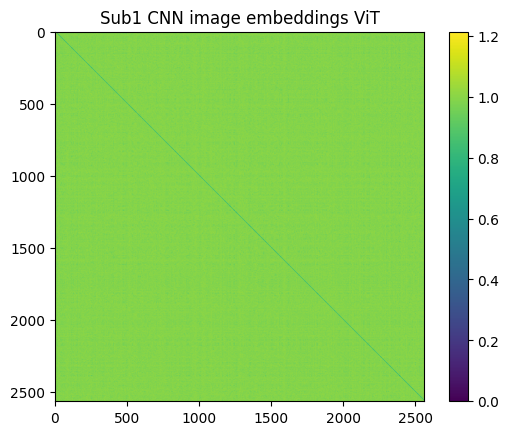

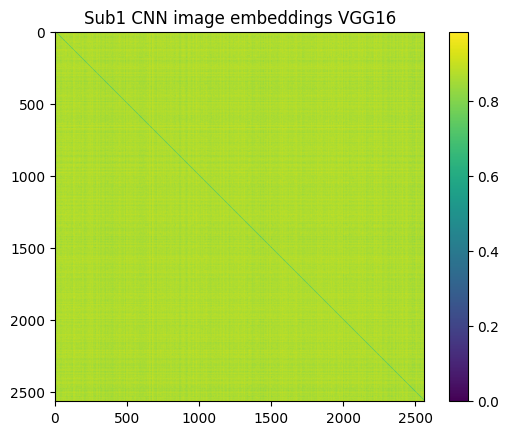

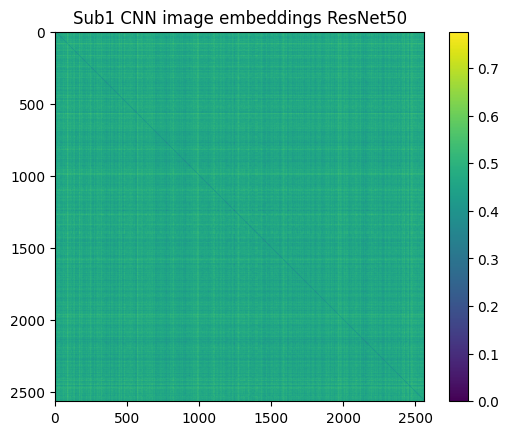

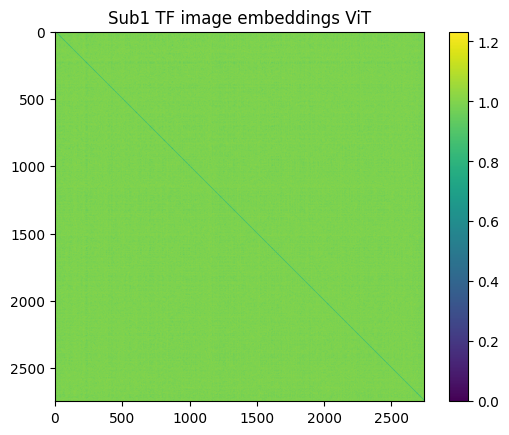

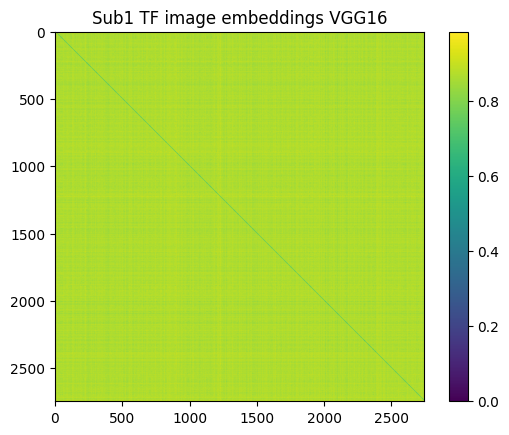

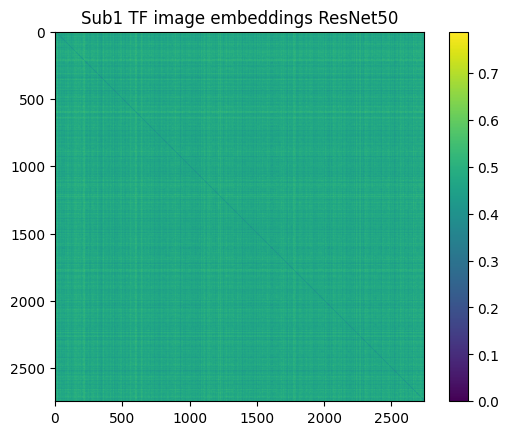

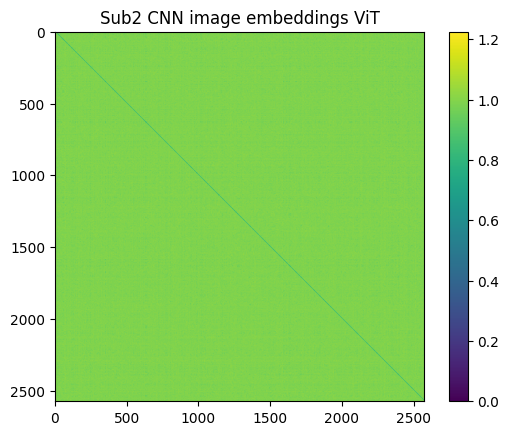

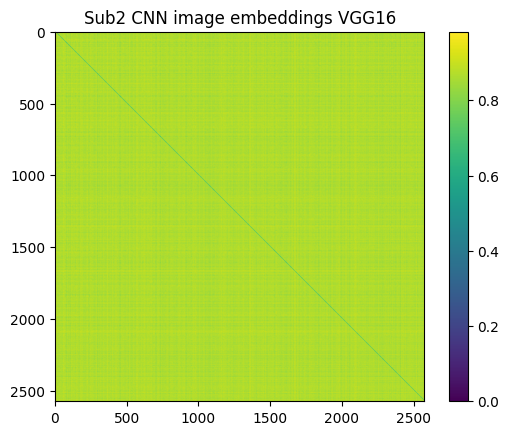

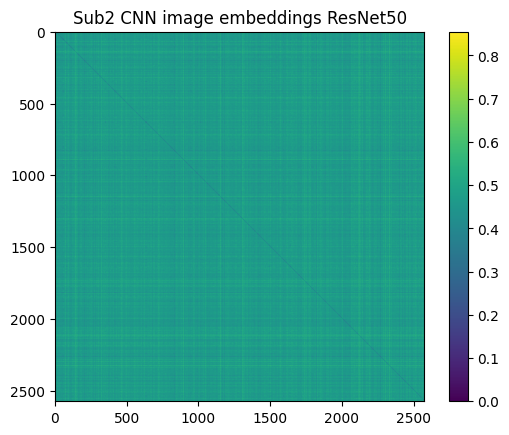

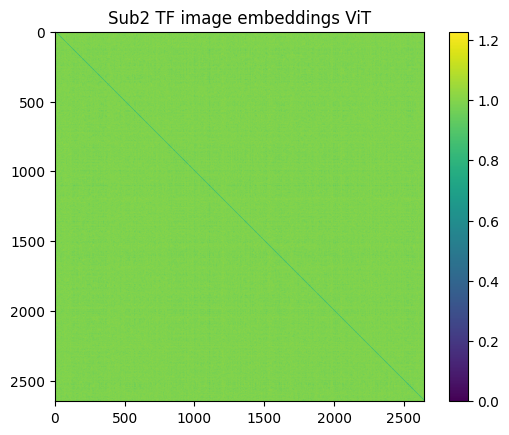

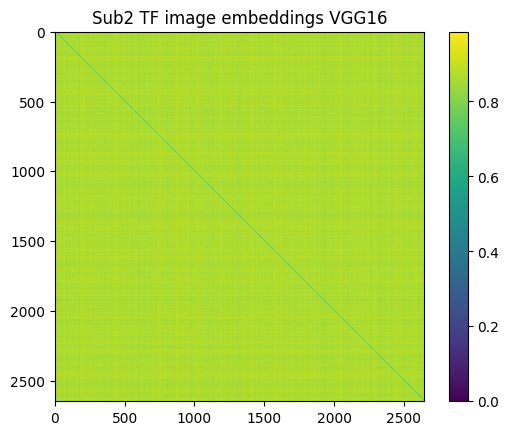

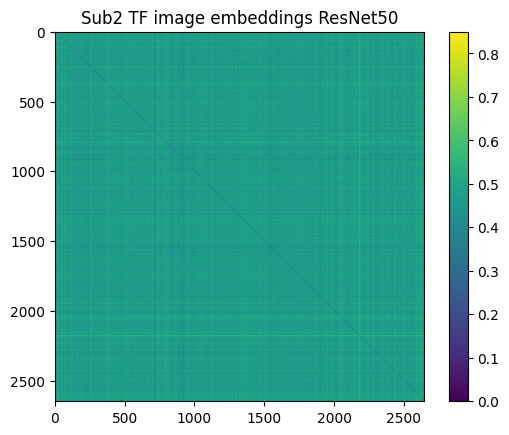

In [21]:
# viz
viz_rdm(sub1_cnn_img_vit_rdm, "Sub1 CNN image embeddings ViT")
viz_rdm(sub1_cnn_img_vgg16_rdm, "Sub1 CNN image embeddings VGG16")
viz_rdm(sub1_cnn_img_resnet50_rdm, "Sub1 CNN image embeddings ResNet50")
viz_rdm(sub1_tf_img_vit_rdm, "Sub1 TF image embeddings ViT")
viz_rdm(sub1_tf_img_vgg16_rdm, "Sub1 TF image embeddings VGG16")
viz_rdm(sub1_tf_img_resnet50_rdm, "Sub1 TF image embeddings ResNet50")
viz_rdm(sub2_cnn_img_vit_rdm, "Sub2 CNN image embeddings ViT")
viz_rdm(sub2_cnn_img_vgg16_rdm, "Sub2 CNN image embeddings VGG16")
viz_rdm(sub2_cnn_img_resnet50_rdm, "Sub2 CNN image embeddings ResNet50")
viz_rdm(sub2_tf_img_vit_rdm, "Sub2 TF image embeddings ViT")
viz_rdm(sub2_tf_img_vgg16_rdm, "Sub2 TF image embeddings VGG16")
viz_rdm(sub2_tf_img_resnet50_rdm, "Sub2 TF image embeddings ResNet50")

This looks a bit complicated and crowded: so what do I do?
I can now get the correlation matrices, between the three vision models and the eye embeddings for all 4 models (2 participants X 2 models). And plot that in MDS space

In [15]:
def get_lower_part(matrix):
    lower = np.tril(matrix, -1)
    lower = lower[lower != 0]
    return lower

In [16]:
def get_corr_matrix(rdms_list):
    rdm_corr = np.zeros((len(rdms_list), len(rdms_list)))
    for i in range(len(rdms_list)):
        for j in range(len(rdms_list)):
            rdm_corr[i, j] = 1 - np.corrcoef(get_lower_part(rdms_list[i]), get_lower_part(rdms_list[j]))[0, 1]
    return rdm_corr

So now I can get the correlation matrices for all subjects and models.

In [24]:
sub1_cnn_corrs = get_corr_matrix([sub1_cnn_eye_rdm, sub1_cnn_img_vit_rdm, sub1_cnn_img_vgg16_rdm, sub1_cnn_img_resnet50_rdm])
sub1_tf_corrs = get_corr_matrix([sub1_tf_eye_rdm, sub1_tf_img_vit_rdm, sub1_tf_img_vgg16_rdm, sub1_tf_img_resnet50_rdm])
sub2_cnn_corrs = get_corr_matrix([sub2_cnn_eye_rdm, sub2_cnn_img_vit_rdm, sub2_cnn_img_vgg16_rdm, sub2_cnn_img_resnet50_rdm])
sub2_tf_corrs = get_corr_matrix([sub2_tf_eye_rdm, sub2_tf_img_vit_rdm, sub2_tf_img_vgg16_rdm, sub2_tf_img_resnet50_rdm])

And now I can plot heatmaps for the correlation matrices.

In [27]:
print(sub1_cnn_corrs)

[[0.00000000e+00 9.98642522e-01 9.93028436e-01 1.00477999e+00]
 [9.98642522e-01 1.11022302e-16 8.38548720e-01 6.49163064e-01]
 [9.93028436e-01 8.38548720e-01 0.00000000e+00 7.39415105e-01]
 [1.00477999e+00 6.49163064e-01 7.39415105e-01 0.00000000e+00]]


In [28]:
def viz_corr_matrix(corr_matrix, title):
    plt.imshow(corr_matrix, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    # x ticks and y tciks are same and eye, vit, vgg16, resnet50
    plt.xticks(np.arange(4), ["Eye", "ViT", "VGG16", "ResNet50"])
    plt.yticks(np.arange(4), ["Eye", "ViT", "VGG16", "ResNet50"])
    plt.show()

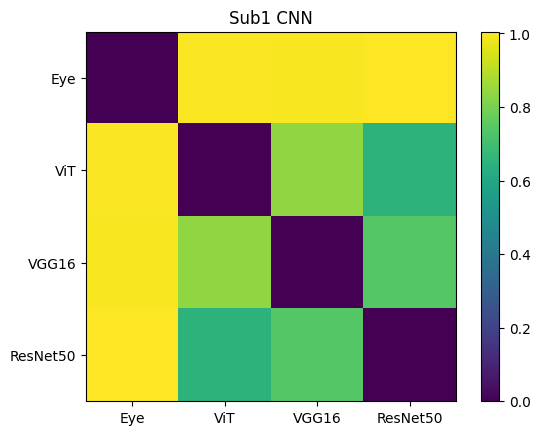

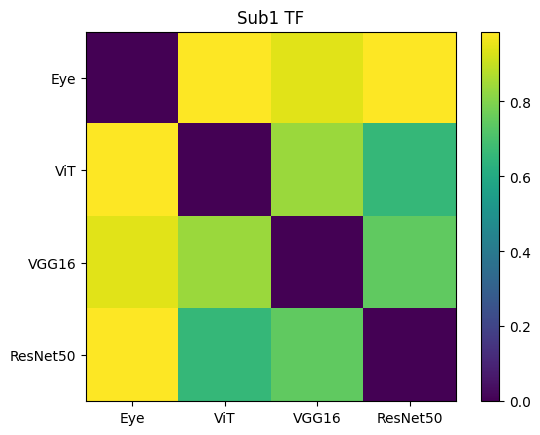

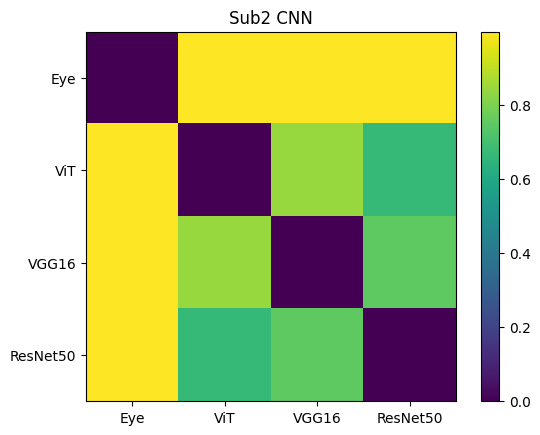

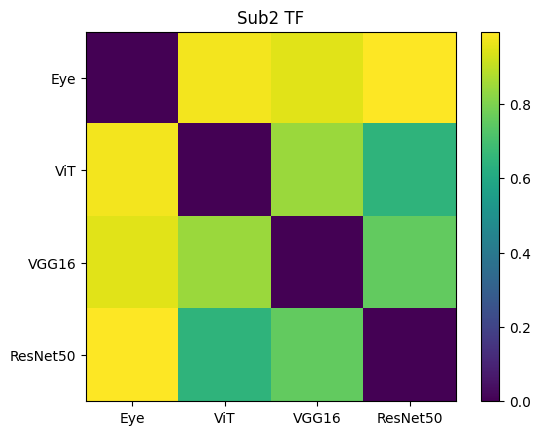

In [29]:
viz_corr_matrix(sub1_cnn_corrs, "Sub1 CNN")
viz_corr_matrix(sub1_tf_corrs, "Sub1 TF")
viz_corr_matrix(sub2_cnn_corrs, "Sub2 CNN")
viz_corr_matrix(sub2_tf_corrs, "Sub2 TF")

Ok, now this is cool! Of course all vision models are roughly related to each other, but the eye embeddings are not really related to the vision embeddings.
The interesting thing is: VGG is more similar than ViT to my eye embeddings, even though the eye model was trained with ViT features.
So: the magic in our contrastive learning really happened thanks to the non linear projection into latent space and not in the representations of each modality.
Lets visualize it with MDS:
Also I will highlight the shortest distance.

In [18]:
def viz_mds(corr_matrix, title):
    mds = MDS(n_components=2, dissimilarity='precomputed')
    mds_transformed = mds.fit_transform(corr_matrix)
    plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1])
    # make list eye, vit, vgg16, resnet50
    ann_list = ["Eye", "ViT", "VGG16", "ResNet50"]
    for i in range(len(corr_matrix)):
        plt.annotate(f"{ann_list[i]}", (mds_transformed[i, 0], mds_transformed[i, 1]))
    # draw lines between all points
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            plt.plot([mds_transformed[i, 0], mds_transformed[j, 0]], [mds_transformed[i, 1], mds_transformed[j, 1]], color="black", alpha=0.2)
    plt.title(title)
    plt.show()

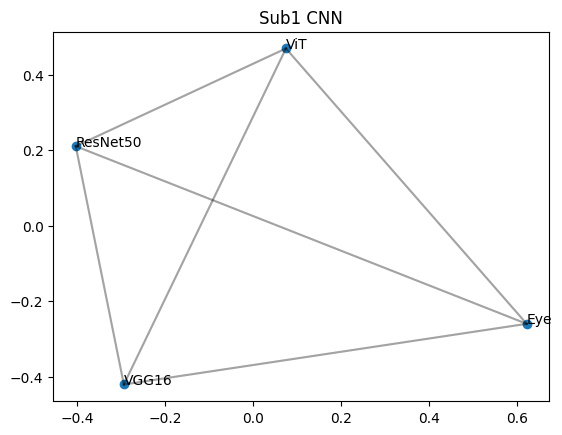

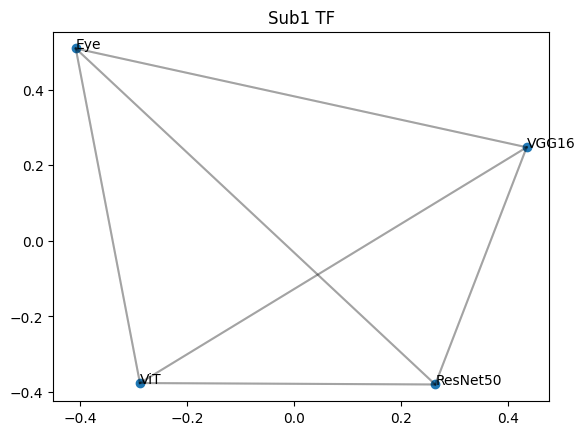

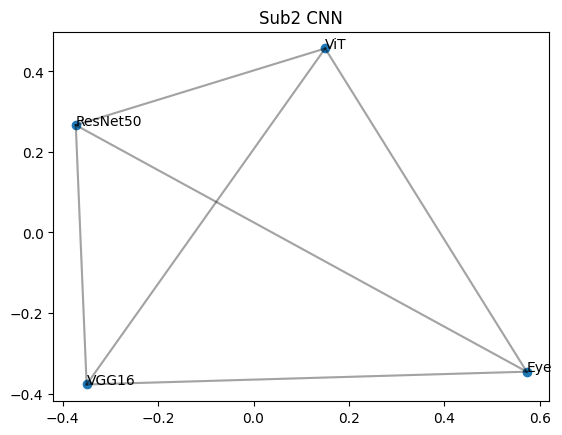

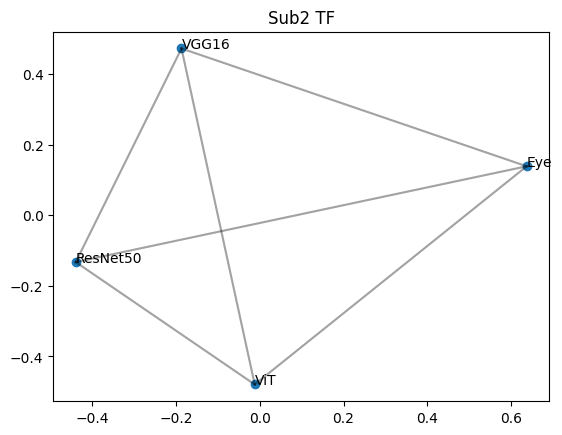

In [31]:
viz_mds(sub1_cnn_corrs, "Sub1 CNN")
viz_mds(sub1_tf_corrs, "Sub1 TF")
viz_mds(sub2_cnn_corrs, "Sub2 CNN")
viz_mds(sub2_tf_corrs, "Sub2 TF")

So I see, the same patterns, as expected from the correlation matrices: the eye embeddings are not really related to the vision embeddings. Which shows again: it is more in the non linear projection than in the representations.

## Evolution of the CNN embeddings
Now our CNN eye encoder has multiple layers, so I can check how the similarity evolves through the layers. As a staple, I will use the ViT embeddings. For this I will only take a subset of 1000 trials, to alleviate compute.
So first: I need to get our CNN features:

In [19]:
sub1_cnn_model_1st= torch.nn.Sequential(*(list(sub1_cnn_model.children())[:-5]))
sub1_cnn_model_2nd= torch.nn.Sequential(*(list(sub1_cnn_model.children())[:-4]))
sub1_cnn_model_3rd= torch.nn.Sequential(*(list(sub1_cnn_model.children())[:-3]))
# last one is already the final embedding
# also for sub 2
sub2_cnn_model_1st= torch.nn.Sequential(*(list(sub2_cnn_model.children())[:-5]))
sub2_cnn_model_2nd= torch.nn.Sequential(*(list(sub2_cnn_model.children())[:-4]))
sub2_cnn_model_3rd= torch.nn.Sequential(*(list(sub2_cnn_model.children())[:-3]))

Now lets put it through our previously defined function.

In [23]:
sub1_cnn_eye_1st = get_eye_embeddings(sub1_cnn_model_1st, sub1_cnn_eye_gt[:1000])
sub1_cnn_eye_2nd = get_eye_embeddings(sub1_cnn_model_2nd, sub1_cnn_eye_gt[:1000])
sub1_cnn_eye_3rd = get_eye_embeddings(sub1_cnn_model_3rd, sub1_cnn_eye_gt[:1000])
sub1_cnn_eye_4th = get_eye_embeddings(sub1_cnn_model, sub1_cnn_eye_gt[:1000])

sub2_cnn_eye_1st = get_eye_embeddings(sub2_cnn_model_1st, sub2_cnn_eye_gt[:1000])
sub2_cnn_eye_2nd = get_eye_embeddings(sub2_cnn_model_2nd, sub2_cnn_eye_gt[:1000])
sub2_cnn_eye_3rd = get_eye_embeddings(sub2_cnn_model_3rd, sub2_cnn_eye_gt[:1000])
sub2_cnn_eye_4th = get_eye_embeddings(sub2_cnn_model, sub2_cnn_eye_gt[:1000])

100%|██████████| 1000/1000 [00:08<00:00, 112.42it/s]


Now lets compute all RDMs:

In [24]:
sub1_cnn_eye_1st_rdm = get_rdm(sub1_cnn_eye_1st)
sub1_cnn_eye_2nd_rdm = get_rdm(sub1_cnn_eye_2nd)
sub1_cnn_eye_3rd_rdm = get_rdm(sub1_cnn_eye_3rd)
sub1_cnn_eye_4th_rdm = get_rdm(sub1_cnn_eye_4th)

sub2_cnn_eye_1st_rdm = get_rdm(sub2_cnn_eye_1st)
sub2_cnn_eye_2nd_rdm = get_rdm(sub2_cnn_eye_2nd)
sub2_cnn_eye_3rd_rdm = get_rdm(sub2_cnn_eye_3rd)
sub2_cnn_eye_4th_rdm = get_rdm(sub2_cnn_eye_4th)

And now I can compute the correlation matrices:

In [25]:
sub1_cnn_corrs = get_corr_matrix([sub1_cnn_eye_1st_rdm, sub1_cnn_eye_2nd_rdm, sub1_cnn_eye_3rd_rdm, sub1_cnn_eye_4th_rdm, sub1_cnn_img_vit_rdm[:1000,:1000]])
sub2_cnn_corrs = get_corr_matrix([sub2_cnn_eye_1st_rdm, sub2_cnn_eye_2nd_rdm, sub2_cnn_eye_3rd_rdm, sub2_cnn_eye_4th_rdm, sub2_cnn_img_vit_rdm[:1000,:1000]])

And just get the row of ViT embedding correlation:

In [34]:
print(sub1_cnn_corrs[:-1, -1])
print(sub2_cnn_corrs[:-1, -1])

def plot_corr_evolution(sub1, sub2, title):
    fig, ax = plt.subplots(1,2, figsize=(15, 5), sharex=True)

    ax[0].plot(sub1)
    ax[0].set_xticks(np.arange(4))
    #ax[0].set_xticklabels(["1st conv", "1st basic block", "2nd basic block", "3rd basic block", "final"])
    ax[0].set_title("Sub1")
    ax[1].plot(sub2)
    ax[1].set_title("Sub2")
    ax[1].set_xticks(np.arange(4))
    ax[1].set_xticklabels(["1st basic block", "2nd basic block", "3rd basic block", "final"])
    ax[1].set_xticklabels(["1st basic block", "2nd basic block", "3rd basic block", "final"])
    plt.show()

[0.99409366 0.99842754 1.00094547 0.99776465]
[0.98559504 0.98420307 0.99444807 0.99673007]


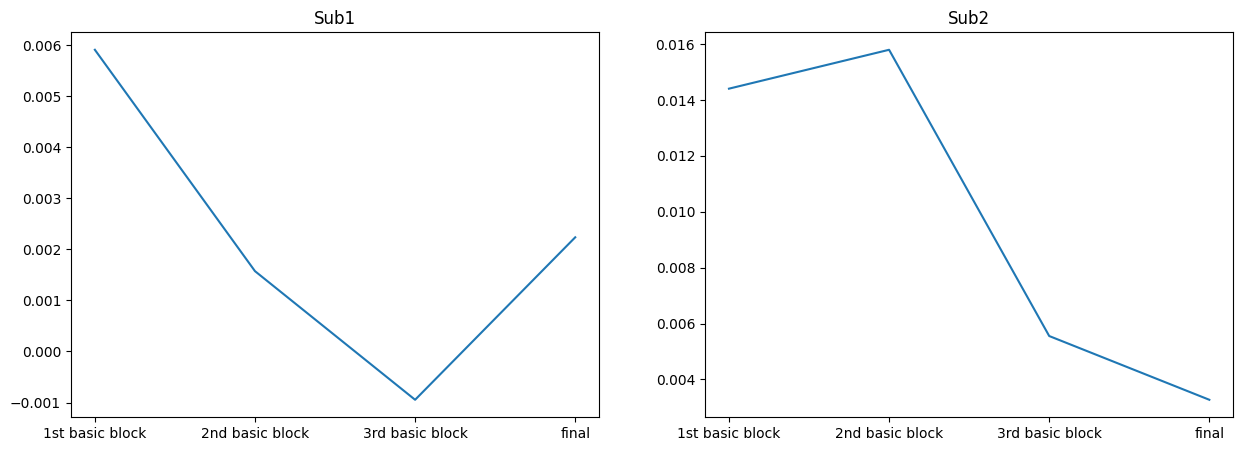

In [35]:
sub1 = sub1_cnn_corrs[:-1, -1]
sub2 = sub2_cnn_corrs[:-1, -1]

plot_corr_evolution(-sub1+1, -sub2+1, "CNN eye embedding evolution")

This is surprising! The model gets more dissimilar to its corresponding vision encoder with deeper layers. This further shows: the representations alone, do not do the trick: it is about the non linear projection layers, on how the matching is performed and also relations between representations are formed there and not in the modality itself.